In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets
import pandas as pd
from functions import *

In [2]:
def plot_function(data_to_plot, title):
    
    def plotimg(idx):
        # Update histogram
        ax[0].clear()
        ax[0].hist(data_to_plot[int(idx)].flatten(), bins = len(np.unique(data_to_plot[int(idx)].flatten())))
        # Update image
        img.set_data(data_to_plot[int(idx),:,:])
        im = ax[1].imshow(data_to_plot[int(idx),:,:], origin='lower', cmap = 'viridis')
        ax[0].axvline(np.nanmedian(data_to_plot[int(idx),:,:]), c = 'r',  alpha = 0.5) # median pixel value
        ax[0].axvline(np.nanmean(data_to_plot[int(idx),:,:]), c = 'g', alpha = 0.5) # mean pixel value
        #plt.colorbar(im)
        fig.canvas.draw_idle()
        
    fig, ax = plt.subplots(ncols = 2, figsize=(12,4))
    img = ax[1].imshow(data_to_plot[0], origin='lower')
    #colorbar = plt.colorbar(img)
    ax[0].set_xlabel('Brightness')
    ax[0].set_ylabel('Nb of pixels')
    plt.suptitle(title, weight = 'bold')

    ipywidgets.interact(plotimg, idx = ipywidgets.FloatSlider(value=0,min=0,max=np.shape(data_to_plot)[0]-1,step=1))
    plt.show()

# Main loop of entire process

In [4]:
### TEST ###   
#def main_loop(Imagettes, Attitude, threshold_mask, threshold_cosmics):

Imagettes = '/home/lui/Documents/thesis/CheopsCosmics/Luise/SAA_visits/CH_PR340102_TG000301_TU2024-05-12T11-29-46_SCI_RAW_Imagette_V0300.fits'
# Imagettes = '/Users/alexisheitzmann/Documents/CHEOPS/Code/SAA_monitoring_MC/SAA_ORs_reduction_pipeline/SAA_visits/CH_PR340102_TG000301_TU2024-05-12T11-29-46_SCI_RAW_Imagette_V0300.fits'
Attitude = '/home/lui/Documents/thesis/CheopsCosmics/Luise/SAA_visits/CH_PR340102_TG000301_TU2024-05-12T11-28-00_SCI_RAW_Attitude_V0300.fits'
threshold_mask = 25
threshold_cosmics = 40

### Get imagettes and plot ###
type_of_visit = 'SAA'
imagettes, header_Imagettes, metadata_Imagettes, nb_imagettes, height_imagettes, width_imagettes = read_imagettes(Imagettes, type_of_visit)
#imagettes = imagettes.astype('float64')
or_id =  str(header_Imagettes['REQ_ID']) + '_' + str(header_Imagettes['VISITCTR'])
visit_start = header_Imagettes['T_STRT_U']
visit_end = header_Imagettes['T_STOP_U']
print(f"{header_Imagettes['TARGNAME']} (PR340102, OR {or_id}): {visit_start}, {np.shape(imagettes)[0]} imagettes.")

### Get mask of edges for later ###
edges_mask = get_edges_mask(imagettes[0])

"""
## WORKING WITH SUBARRAYS ####
size = np.shape(imagettes[0])[0]
radius = np.shape(imagettes[0])[0]/2
mask_circular = create_circular_mask(size, radius)
# Apply mask to subarrays
imagettes = apply_mask_to_imagettes(imagettes, mask_circular, 0)
################################
"""

SAA_morning_May (PR340102, OR 3_1): 2024-05-12T11:29:46.338228, 840 imagettes.


'\n## WORKING WITH SUBARRAYS ####\nsize = np.shape(imagettes[0])[0]\nradius = np.shape(imagettes[0])[0]/2\nmask_circular = create_circular_mask(size, radius)\n# Apply mask to subarrays\nimagettes = apply_mask_to_imagettes(imagettes, mask_circular, 0)\n################################\n'

interactive(children=(FloatSlider(value=0.0, description='idx', max=839.0, step=1.0), Output()), _dom_classes=…

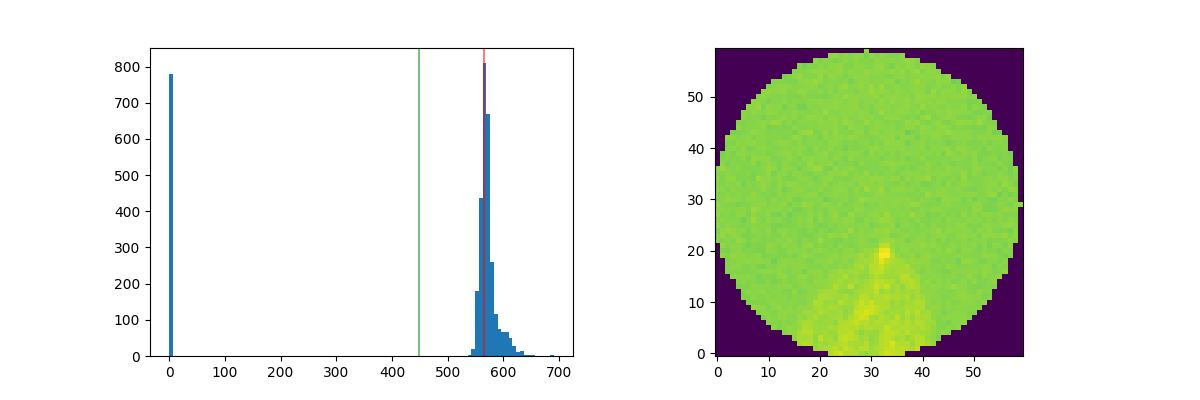

In [4]:
plot_function(imagettes, '')

In [5]:
median_subtracted_imagettes = imagettes.copy()

median_image_per_pixel = np.nanmedian(median_subtracted_imagettes, axis=(0)).astype('uint32')
    # median_image = np.nanmedian(im_Imagettes, axis=(1,2))

for i in range(len(median_subtracted_imagettes)):
    median_subtracted_imagettes[i] = median_subtracted_imagettes[i] - median_image_per_pixel

In [12]:
type(median_image_per_pixel[0,0])

numpy.uint32

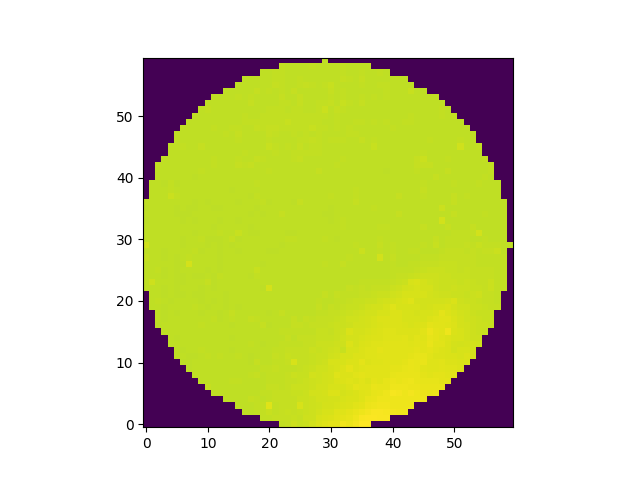

In [13]:
plt.imshow(median_image_per_pixel, origin='lower')
plt.show()

In [5]:
### Subtract the median image ###
median_substracted_imagettes = subtract_median_image(imagettes)
#median_substracted_imagettes = median_substracted_imagettes.astype('uint8')

interactive(children=(FloatSlider(value=0.0, description='idx', max=839.0, step=1.0), Output()), _dom_classes=…

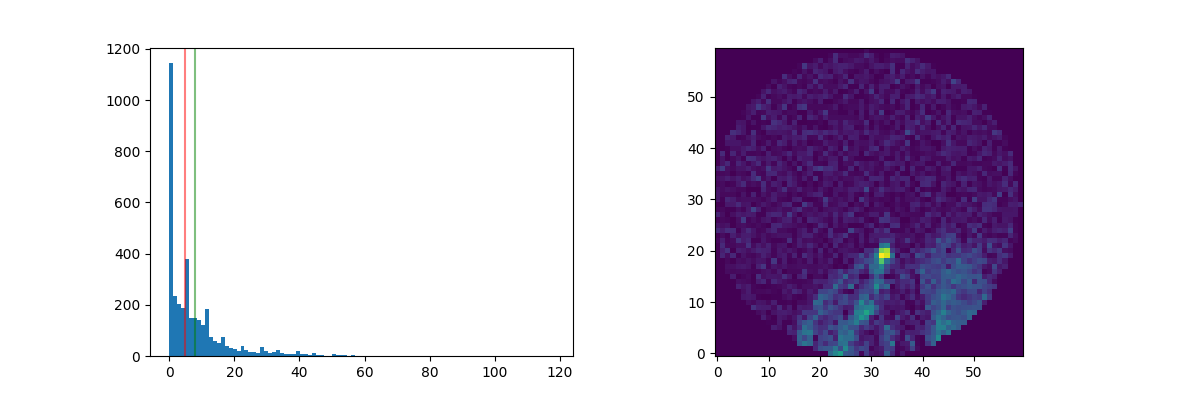

In [6]:
plot_function(median_substracted_imagettes, '')

In [7]:
### Convert to openCV images ###
openCV_imagettes = convert_to_openCV(median_substracted_imagettes, nb_imagettes, height_imagettes, width_imagettes)

interactive(children=(FloatSlider(value=0.0, description='idx', max=839.0, step=1.0), Output()), _dom_classes=…

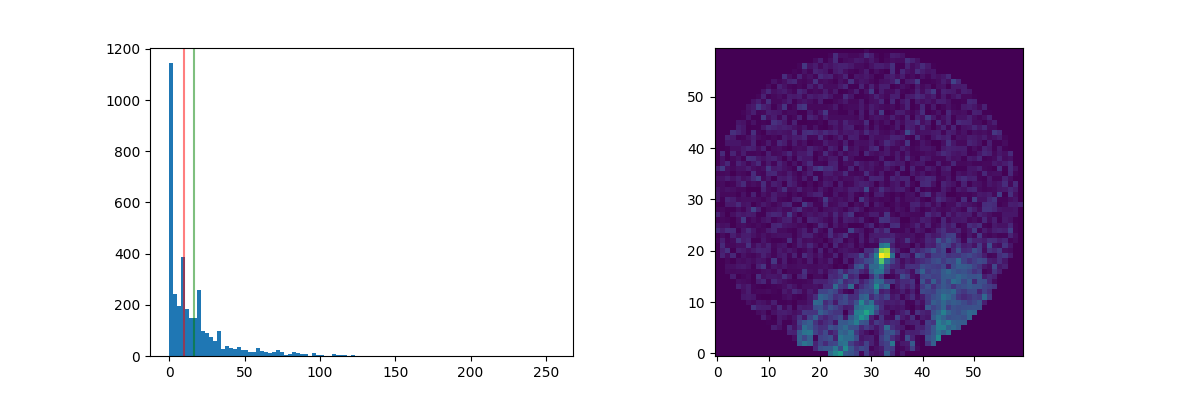

In [8]:
plot_function(openCV_imagettes, '')

In [9]:
### Derotate images ###
derotated_openCV_imagettes, time_imagettes_utc, time_imagettes_utc_jd = derotate_images(Attitude, openCV_imagettes, metadata_Imagettes, nb_imagettes, height_imagettes, width_imagettes)

In [23]:
plt.close('all')

interactive(children=(FloatSlider(value=0.0, description='idx', max=839.0, step=1.0), Output()), _dom_classes=…

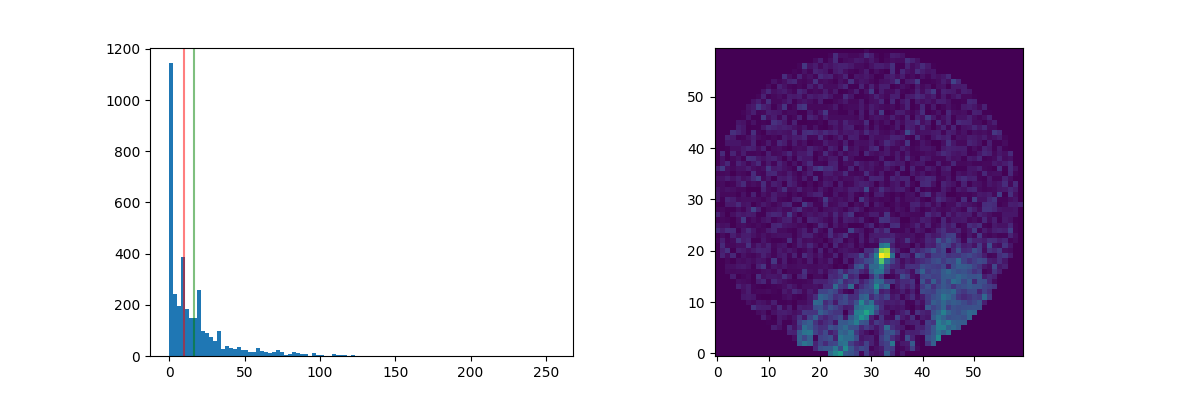

In [10]:
plot_function(derotated_openCV_imagettes, '')

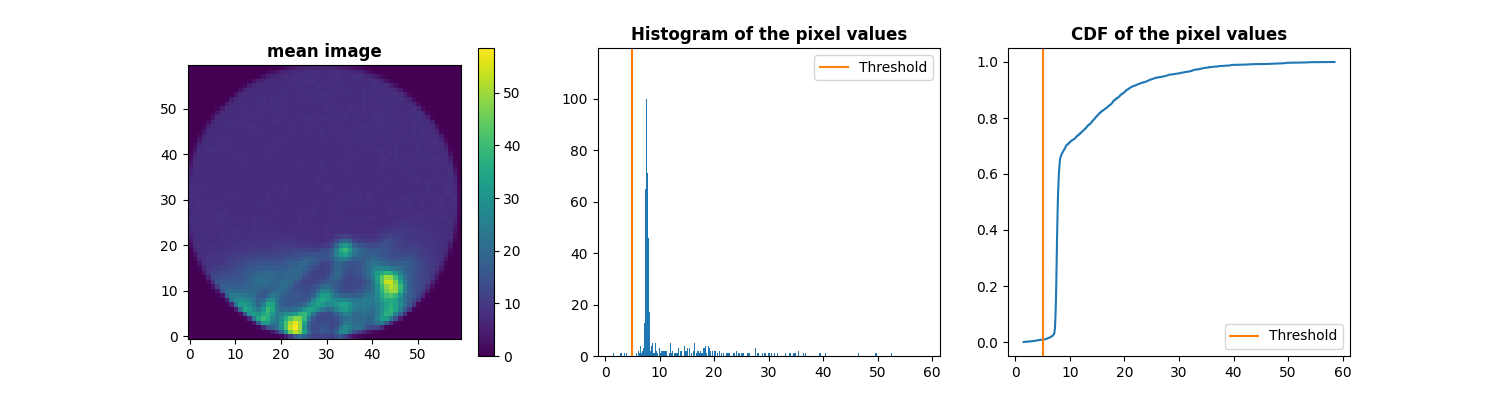

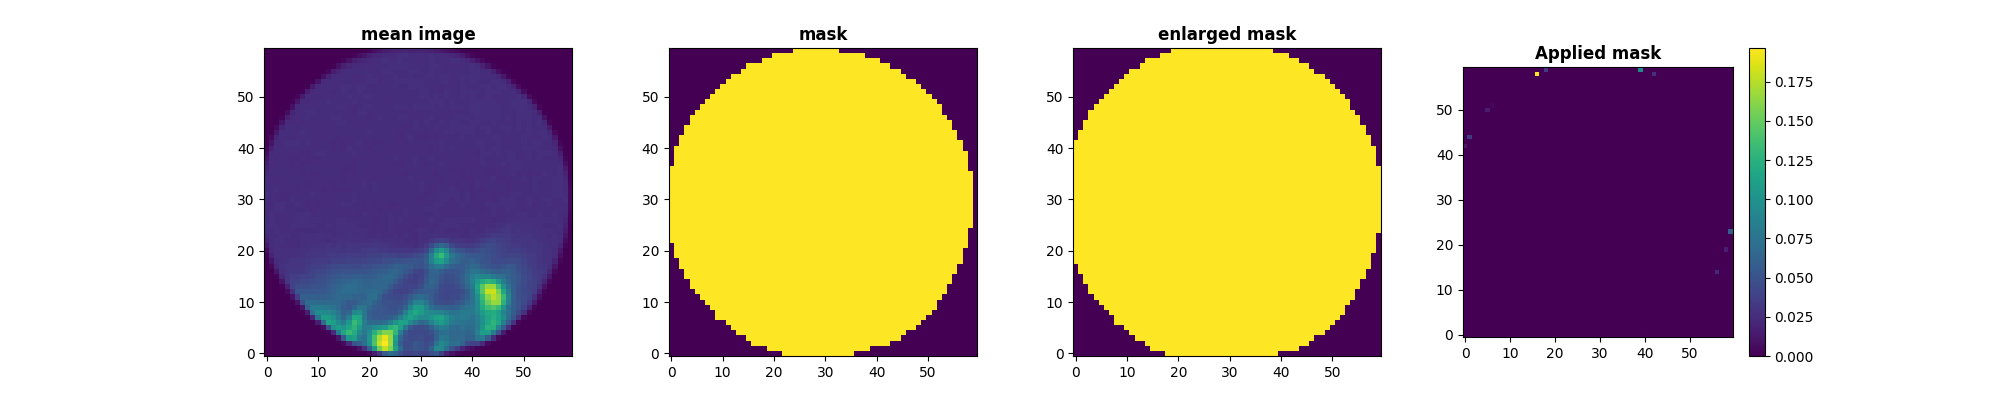

In [12]:
### Design mask for contaminant ###
enlarge_mask = True
inspect_threshold = True
inspect_mask = True
mask = create_contaminant_mask(derotated_openCV_imagettes, threshold_mask, edges_mask, enlarge_mask, inspect_threshold, inspect_mask)

In [ ]:
### Apply mask ###
masked_imagettes = apply_mask_to_imagettes(derotated_openCV_imagettes, mask, 0)

In [ ]:
### Detect cosmics ###
binary_images, nb_cosmics, imagettes_contours = detect_cosmics(masked_imagettes, threshold_cosmics) 

In [ ]:
# Cosmic per cm2
nb_masked_pixels = np.sum(edges_mask.flatten()) + np.sum(mask.flatten()) # number of pixels that are masked (edged + mask)
fraction_remaining_pixels = (height_imagettes*width_imagettes) - nb_masked_pixels
pixel_size = 0.015*0.015 # cm2
cm2_analysed = pixel_size*fraction_remaining_pixels
density_cosmics = nb_cosmics/cm2_analysed # nb cosmics per cm2

print(f'{nb_masked_pixels} masked pixels')

flattened_imagettes           = [image.flatten() for image in imagettes]
flattened_derotated_imagettes = [image.flatten() for image in derotated_openCV_imagettes]
flattened_masked_imagettes    = [image.flatten() for image in masked_imagettes]
flattened_binary_imagettes    = [image.flatten() for image in binary_images]

flattened_mask = []
for i in range(len(imagettes)):
    flattened_mask.append(mask.flatten())

#MJD_time = time_imagette+2400000

data = pd.DataFrame(data =    {
                            'visit_ID': np.full(nb_imagettes, or_id),
                            'raw_imagettes': flattened_imagettes,
                            'derotated_imagettes': flattened_derotated_imagettes,
                            'masked_imagettes': flattened_masked_imagettes, 
                            'binary_imagettes': flattened_binary_imagettes, 
                            'mask': flattened_mask,
                            'JD': time_imagettes_utc_jd,
                            'time': time_imagettes_utc,
                            'nb_cosmics' : nb_cosmics.astype(int),
                            'density_cosmics' : density_cosmics,
                            'pix_cosmics': imagettes_contours,
                            'im_height': np.full(nb_imagettes, height_imagettes),
                            'im_width': np.full(nb_imagettes, width_imagettes)
                            }
)

data.set_index('JD',drop = True, inplace = True) # set index to JD

### Crossmathc with LAT/LON from the restituted orbit ###

#### TO DO #####
# once the code is on the compute node, fetch directly the res orb files and compute the master orb res file
# in the meantime:
# - go on cn04 and compute the most recent master_orb_res using the MC_SAA_script.py in /home/astro/heitzman/SAA_mapping/SAA_OR
# - run: scp cn04:/home/astro/heitzman/SAA_mapping/master_orb_res.csv /Users/alexisheitzmann/Documents/CHEOPS/Code/SAA_monitoring_MC/SAA_ORs_reduction_pipeline/


###############

# get restituted orbit master file
data_res_orb = pd.read_csv('/Users/alexisheitzmann/Documents/CHEOPS/Code/SAA_monitoring_MC/SAA_ORs_reduction_pipeline/master_orb_res.csv')
data_res_orb.set_index('JD',drop = True, inplace = True) # set index to JD
data_res_orb.sort_index()
data_RES = data_res_orb.copy()
# Use only the part of the restitued around the visit, +/- 1 day to have enough baseline for the interpolation
time_min = data.index.min() - 1
time_max = data.index.max() + 1
data_RES = data_RES[(data_RES.index > time_min) & (data_RES.index < time_max)]
# Interpolate LAT/LON at the time of the imagettes
data_interp = unfold_interp_fold(data_RES, data, order = 3)


In [ ]:
# main function #  
def main_loop(Imagettes, Attitude, threshold_mask, threshold_cosmics):

    # Imagettes = '/Users/alexisheitzmann/Documents/CHEOPS/Code/SAA_monitoring_MC/SAA_ORs_reduction_pipeline/SAA_visits/CH_PR340102_TG000301_TU2024-05-12T11-29-53_SCI_RAW_SubArray_V0300.fits'
    # Attitude = '/Users/alexisheitzmann/Documents/CHEOPS/Code/SAA_monitoring_MC/SAA_ORs_reduction_pipeline/SAA_visits/CH_PR340102_TG000301_TU2024-05-12T11-28-00_SCI_RAW_Attitude_V0300.fits'
    # threshold_mask = 40
    # threshold_cosmics = 40

    ### Get imagettes and plot ###
    type_of_visit = 'science'
    imagettes, header_Imagettes, metadata_Imagettes, nb_imagettes, height_imagettes, width_imagettes = read_imagettes(Imagettes, type_of_visit)
    or_id =  str(header_Imagettes['REQ_ID']) + '_' + str(header_Imagettes['VISITCTR'])
    visit_start = header_Imagettes['T_STRT_U']
    visit_end = header_Imagettes['T_STOP_U']
    print(f"{header_Imagettes['TARGNAME']} (PR340102, OR {or_id}): {visit_start}, {np.shape(imagettes)[0]} imagettes.")

    ### Get mask of edges for later ###
    # edges_mask = get_edges_mask(imagettes[0])


    ## WORKING WITH SUBARRAYS ####
    size = np.shape(imagettes[0])[0]
    radius = np.shape(imagettes[0])[0]/2
    edges_mask = create_circular_mask(size, radius)
    # Apply mask to subarrays
    imagettes = apply_mask_to_imagettes(imagettes, edges_mask, 0)
    ################################

    ### Subtract the median image ###
    median_substracted_imagettes = subtract_median_image(imagettes)

    ### Convert to openCV images ###
    openCV_imagettes = convert_to_openCV(median_substracted_imagettes, nb_imagettes, height_imagettes, width_imagettes)

    ### Derotate images ###
    derotated_openCV_imagettes, time_imagettes_utc, time_imagettes_utc_jd = derotate_images(Attitude, openCV_imagettes, metadata_Imagettes, nb_imagettes, height_imagettes, width_imagettes)

    ### Design mask for contaminant ###
    enlarge_mask = True
    inspect_threshold = True
    inspect_mask = True

    mask = create_contaminant_mask(derotated_openCV_imagettes, threshold_mask, edges_mask, enlarge_mask, inspect_threshold, inspect_mask)

    ### Apply mask ###
    masked_imagettes = apply_mask_to_imagettes(derotated_openCV_imagettes, mask, 0)

    ### Detect cosmics ###
    binary_images, nb_cosmics, imagettes_contours = detect_cosmics(masked_imagettes, threshold_cosmics) 

    # Cosmic per cm2
    nb_masked_pixels = np.sum(edges_mask.flatten()) + np.sum(mask.flatten()) # number of pixels that are masked (edged + mask)
    fraction_remaining_pixels = (height_imagettes*width_imagettes) - nb_masked_pixels
    pixel_size = 0.015*0.015 # cm2
    cm2_analysed = pixel_size*fraction_remaining_pixels
    density_cosmics = nb_cosmics/cm2_analysed # nb cosmics per cm2

    print(f'{nb_masked_pixels} masked pixels')

    flattened_imagettes           = [image.flatten() for image in imagettes]
    flattened_derotated_imagettes = [image.flatten() for image in derotated_openCV_imagettes]
    flattened_masked_imagettes    = [image.flatten() for image in masked_imagettes]
    flattened_binary_imagettes    = [image.flatten() for image in binary_images]

    flattened_mask = []
    for i in range(len(imagettes)):
        flattened_mask.append(mask.flatten())

    #MJD_time = time_imagette+2400000

    data = pd.DataFrame(data =    {
                                'visit_ID': np.full(nb_imagettes, or_id),
                                'raw_imagettes': flattened_imagettes,
                                'derotated_imagettes': flattened_derotated_imagettes,
                                'masked_imagettes': flattened_masked_imagettes, 
                                'binary_imagettes': flattened_binary_imagettes, 
                                'mask': flattened_mask,
                                'JD': time_imagettes_utc_jd,
                                'time': time_imagettes_utc,
                                'nb_cosmics' : nb_cosmics.astype(int),
                                'density_cosmics' : density_cosmics,
                                'pix_cosmics': imagettes_contours,
                                'im_height': np.full(nb_imagettes, height_imagettes),
                                'im_width': np.full(nb_imagettes, width_imagettes)
                                }
    )

    data.set_index('JD',drop = True, inplace = True) # set index to JD

    ### Crossmathc with LAT/LON from the restituted orbit ###

    #### TO DO #####
    # once the code is on the compute node, fetch directly the res orb files and compute the master orb res file
    # in the meantime:
    # - go on cn04 and compute the most recent master_orb_res using the MC_SAA_script.py in /home/astro/heitzman/SAA_mapping/SAA_OR
    # - run: scp cn04:/home/astro/heitzman/SAA_mapping/master_orb_res.csv /Users/alexisheitzmann/Documents/CHEOPS/Code/SAA_monitoring_MC/SAA_ORs_reduction_pipeline/


    ###############

    # get restituted orbit master file
    data_res_orb = pd.read_csv('/Users/alexisheitzmann/Documents/CHEOPS/Code/SAA_monitoring_MC/SAA_ORs_reduction_pipeline/master_orb_res.csv')
    data_res_orb.set_index('JD',drop = True, inplace = True) # set index to JD
    data_res_orb.sort_index()
    data_RES = data_res_orb.copy()
    # Use only the part of the restitued around the visit, +/- 1 day to have enough baseline for the interpolation
    time_min = data.index.min() - 1
    time_max = data.index.max() + 1
    data_RES = data_RES[(data_RES.index > time_min) & (data_RES.index < time_max)]
    # Interpolate LAT/LON at the time of the imagettes
    data_interp = unfold_interp_fold(data_RES, data, order = 3)


    return data_interp, data_res_orb

In [ ]:
# get list of files

# for local run, get the imagettes and attitude files
# scp cn:"/projects/astro/cheops/processing/chpscn02/opt/monitor4cheops/Operations/repository/visit/PR34/PR340102_TG00*/*Imagette*" SAA_ORs_reduction_pipeline/SAA_visits
# scp cn:"/projects/astro/cheops/processing/chpscn02/opt/monitor4cheops/Operations/repository/visit/PR34/PR340102_TG00*/*Attitude*" SAA_ORs_reduction_pipeline/SAA_visits


directory_path = '/Users/alexisheitzmann/Documents/CHEOPS/Code/SAA_monitoring_MC/SAA_ORs_reduction_pipeline/SAA_visits/test_visits'
substring = 'RAW_SubArray'
Imagettes = get_files_with_substring(directory_path, substring)
Imagettes.sort()

directory_path = '/Users/alexisheitzmann/Documents/CHEOPS/Code/SAA_monitoring_MC/SAA_ORs_reduction_pipeline/SAA_visits/test_visits'
substring = 'RAW_Attitude'
Attitudes = get_files_with_substring(directory_path, substring)
Attitudes.sort()

# Run main loop 

# imagette values
# threshold_mask = 5
# threshold_cosmics = 40

# science values 
threshold_mask = 30
threshold_cosmics = 100

# For a single visit
# visit_idx = 0
# all_data, restituted_orbit = main_loop(Imagettes[visit_idx], Attitudes[visit_idx], threshold_mask, threshold_cosmics)

# For all visits

all_data = pd.DataFrame()
restituted_orbit = pd.DataFrame()
for i in range(len(Imagettes)):
    visit = Imagettes[i].split('/')[9][3:20]
    print(f'Processing visit {visit}...')
    df, _ = main_loop(Imagettes[i], Attitudes[i], threshold_mask, threshold_cosmics)
    if i == (len(Imagettes))-1:
        df, restituted_orbit = main_loop(Imagettes[i], Attitudes[i], threshold_mask, threshold_cosmics)
    all_data = pd.concat([all_data, df], ignore_index=False)
    #restituted_orbit = pd.concat([restituted_orbit, data_RES], ignore_index=False)
    
restituted_orbit = restituted_orbit.sort_index()    
all_data = all_data.sort_index()

# Plot some imagettes

In [ ]:
# # reshape images
# # imagettes_type = 'raw_imagettes'
# imagettes_type = 'derotated_imagettes'
# # imagettes_type = 'masked_imagettes'
# # imagettes_type = 'binary_imagettes'

# reshaped_imagettes = reshape_flatten_images(imagettes_type, all_data)

# # plot
# plot_function(reshaped_imagettes, imagettes_type)

# Detections

In [ ]:
detections = all_data[all_data['nb_cosmics'] != 0]
max_cosmics = np.max(detections['nb_cosmics'])
print(f'Frame with most cosmics has {max_cosmics} cosmics')

non_detections = all_data[all_data['nb_cosmics'] == 0]

In [ ]:
data_to_plot1 = reshape_flatten_images('derotated_imagettes', detections) 
data_to_plot2 = reshape_flatten_images('masked_imagettes', detections) 
data_to_plot3 = reshape_flatten_images('binary_imagettes', detections) 
cosmics = detections['nb_cosmics'].values
density_cosmics = detections['density_cosmics'].values

def plotimg(idx):
    
    # Update histogram
    ax[0].clear()
    ax[0].hist(data_to_plot1[int(idx)].flatten(), bins = int(np.max(data_to_plot1[int(idx)].flatten())))
    #ax[0].set_xlim(1,np.max(data_to_plot[int(idx)].flatten()))
    # Update image
    img1.set_data(data_to_plot1[int(idx)])
    img2.set_data(data_to_plot2[int(idx)])
    img3.set_data(data_to_plot3[int(idx)])
    ax[1].imshow(data_to_plot1[int(idx)], origin='lower', cmap = 'viridis')
    ax[2].imshow(data_to_plot2[int(idx)], origin='lower', cmap = 'viridis')
    ax[3].imshow(data_to_plot3[int(idx)], origin='lower', cmap = 'viridis')
    ax[0].axvline(threshold_cosmics, c = 'r',  alpha = 0.5) # median pixel value
    ax[0].text(0.25,0.9,f'{int(cosmics[int(idx)])} CRs detected: {np.round(density_cosmics[int(idx)],1)} CR/cm2', weight = 'bold', transform=ax[0].transAxes)
    #plt.colorbar(im)
    fig.canvas.draw_idle()
    
fig, ax = plt.subplots(ncols = 4, figsize=(20,4))
img1 = ax[1].imshow(data_to_plot1[0], origin='lower')
ax[1].set_title('Derotated, median subtracted imagettes')
img2 = ax[2].imshow(data_to_plot2[0], origin='lower')
ax[2].set_title('Masked imagettes')
img3 = ax[3].imshow(data_to_plot3[0], origin='lower')
ax[3].set_title('Detected cosmic rays')
#colorbar = plt.colorbar(img)
ax[0].set_xlabel('Brightness')
ax[0].set_ylabel('Nb of pixels')

fig.suptitle(f'DETECTIONS', weight = 'bold')
ipywidgets.interact(plotimg, idx = ipywidgets.FloatSlider(value=0,min=0,max=np.shape(data_to_plot1)[0]-1,step=1))
plt.show()

# Non detections

In [ ]:
data_to_plot1 = reshape_flatten_images('derotated_imagettes', non_detections) 
data_to_plot2 = reshape_flatten_images('masked_imagettes', non_detections) 
data_to_plot3 = reshape_flatten_images('binary_imagettes', non_detections) 
cosmics = non_detections['nb_cosmics'].values
cosmics_density = non_detections['density_cosmics'].values

def plotimg(idx):
    
    # Update histogram
    ax[0].clear()
    ax[0].hist(data_to_plot1[int(idx)].flatten(), bins = int(np.max(data_to_plot1[int(idx)].flatten())))
    #ax[0].set_xlim(1,np.max(data_to_plot[int(idx)].flatten()))
    # Update image
    img1.set_data(data_to_plot1[int(idx)])
    img2.set_data(data_to_plot2[int(idx)])
    #img3.set_data(data_to_plot3[int(idx)])
    ax[1].imshow(data_to_plot1[int(idx)], origin='lower', cmap = 'viridis')
    ax[2].imshow(data_to_plot2[int(idx)], origin='lower', cmap = 'viridis')
    #ax[3].imshow(data_to_plot3[int(idx)], origin='lower', cmap = 'viridis')
    ax[0].axvline(threshold_cosmics, c = 'r',  alpha = 0.5) # median pixel value
    #plt.colorbar(im)
    fig.canvas.draw_idle()
    
fig, ax = plt.subplots(ncols = 3, figsize=(20,4))
img1 = ax[1].imshow(data_to_plot1[0], origin='lower')
ax[1].set_title('Derotated, median subtracted imagettes')
img2 = ax[2].imshow(data_to_plot2[0], origin='lower')
ax[2].set_title('Masked imagettes')
#img3 = ax[3].imshow(data_to_plot3[0], origin='lower')
#ax[3].set_title('Detected cosmic rays')
#colorbar = plt.colorbar(img)
ax[0].set_xlabel('Brightness')
ax[0].set_ylabel('Nb of pixels')

fig.suptitle('NON DETECTIONS', weight = 'bold')
ipywidgets.interact(plotimg, idx = ipywidgets.FloatSlider(value=0,min=0,max=np.shape(data_to_plot1)[0]-1,step=1))
plt.show()

# Inspect latitude and longitude

In [ ]:
fig, ax = plt.subplots(ncols = 2, figsize=(12,4))
ax[0].plot(restituted_orbit.index,restituted_orbit['LATITUDE'], '.', label = 'restituted orbit')
ax[0].plot(detections.index,detections['LATITUDE'], '.', label = 'imagettes')
ax[0].set_title('LATITUDE')
ax[1].plot(restituted_orbit.index,restituted_orbit['LONGITUDE'], '.', label = 'restituted orbit')
ax[1].plot(detections.index,detections['LONGITUDE'], '.', label = 'imagettes')
ax[1].set_title('LONGITUDE')

# MAP

In [ ]:
import cartopy.crs as ccrs
import matplotlib
from astropy.io import fits
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd

In [ ]:
# Read SAA mask
SAA_file = '/Users/alexisheitzmann/Documents/CHEOPS/Code/SAA_monitoring_MC/SAA_ORs_reduction_pipeline/CH_TU2024-01-16T15-06-00_EXT_APP_SAAMap-690km_V0301.fits'
data_SAA = read_SAA_map(SAA_file)

In [ ]:
#%matplotlib widget
plt.close('all')
fig = plt.figure(figsize=(18, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
#ax = plt.axes(projection=ccrs.Orthographic(-45, -23))
ax.stock_img()
ax.gridlines()


data_plot = all_data


# Plot SAA mask
x = data_SAA['longitude']
y = data_SAA['latitude']
c = data_SAA['SAA_FLAG']
cc = plt.scatter(x,y,c = c, s = 50, alpha = 0.1, marker = 'o', edgecolor='none', transform=ccrs.Geodetic())


x = data_plot['LONGITUDE']
y = data_plot['LATITUDE']
c = np.log10(data_plot['density_cosmics'])

cr = plt.scatter(x,y,c = c, s = 150, alpha = 0.5, marker = '.', transform=ccrs.Geodetic())#, label = labels[i])
plt.colorbar(cr)
 

# labels = ['0','< 4','>= 4', '>= 10']
# colors = ['white','khaki','C1','C3']
# cm = ListedColormap(colors)
# for i in range(4):
#     if i == 0:
#         x = data_plot.loc[data_plot['nb_cosmics'] == 0]['LONGITUDE']
#         y = data_plot.loc[data_plot['nb_cosmics'] == 0]['LATITUDE']
#         alpha = 0.1
        
#     if i == 1:
#         x = data_plot.loc[(data_plot['nb_cosmics'] > 0) & (data_plot['nb_cosmics'] < 4)]['LONGITUDE']
#         y = data_plot.loc[(data_plot['nb_cosmics'] > 0) & (data_plot['nb_cosmics'] < 4)]['LATITUDE']
#         alpha = 0.5
        
#     if i == 2:
#         x = data_plot.loc[(data_plot['nb_cosmics'] >= 4) & (data_plot['nb_cosmics'] < 10)]['LONGITUDE']
#         y = data_plot.loc[(data_plot['nb_cosmics'] >= 4) & (data_plot['nb_cosmics'] < 10)]['LATITUDE']
#         alpha = 0.5
        
#     if i == 3:
#         x = data_plot.loc[data_plot['nb_cosmics'] >= 10]['LONGITUDE']
#         y = data_plot.loc[data_plot['nb_cosmics'] >= 10]['LATITUDE']
#         alpha = 0.7
    
#     cr = plt.scatter(x,y,c = colors[i], s = 20, alpha = alpha, marker = '.', transform=ccrs.Geodetic(), label = labels[i])

# handles = [
#     plt.scatter([], [], s=100, c=colors[0], alpha=0.6, label=labels[0]),
#     plt.scatter([], [], s=100, c=colors[1], alpha=0.6, label=labels[1]),
#     plt.scatter([], [], s=100, c=colors[2], alpha=0.6, label=labels[2]),
#     plt.scatter([], [], s=100, c=colors[3], alpha=0.6, label=labels[3]),

# ]

# Add legend to the plot with custom background color
#legend = plt.legend(handles=handles, title='Nb of CRs in imagette')
#legend.get_frame().set_facecolor('white')    
    
#     cm = ListedColormap(colors)
#     c = data_plot['multi_CRs']
#     plt.colorbar(cr)    
    
# x = data_plot['LONGITUDE']
# y = data_plot['LATITUDE']
# c = data_plot['nb_cosmics']
# cr = plt.scatter(x,y,c = c, alpha = 1, marker = '.', transform=ccrs.Geodetic())
# plt.colorbar(cr)

#labels = ['1 CR','multiple CR']
#colors = ['lightgrey', 'indianred']
# for i, value in enumerate([0,1]):
    # x = data_plot.loc[data_plot['multi_CRs'] == value]['LONGITUDE']
    # y = data_plot.loc[data_plot['multi_CRs'] == value]['LATITUDE']
    #cm = matplotlib.colormaps['tab10']
    #colors = ['lightgrey', 'indianred']
    #cm = ListedColormap(colors)
    #c = data_plot['multi_CRs']
    # plt.scatter(x,y,c = colors[i], s = 25, alpha = 1, marker = '.', transform=ccrs.Geodetic(), label = labels[i])
    #plt.colorbar(label='1 CR vs multiple CRs') 

# plt.legend(frameon=True,bbox_to_anchor=(0.12,0.6),markerscale=2)

# #plt.colorbar(aaa)
# #plt.title('June 28th, at 08:40:00, SAA_FLAG is False in MPS_PRE_VISIT')
# #plt.legend(frameon=True,bbox_to_anchor=(0.7,0),markerscale=1)
# #save_folder = '/Users/alexisheitzmann/Documents/CHEOPS/Code/SSA_mismapping/imagette_mapping/AU_Mic_5_sec_visits/'
# name_addition = 'all'
# save_name = 'map_CR_detections_'+ name_addition + '_' + np.min(full_orb_res_err.index).strftime("%Y-%m-%d") + '_to_' + np.max(full_orb_res_err.index).strftime("%Y-%m-%d") + '.png'
# title = str(len(data_plot)) + ' detections from ' + np.min(full_orb_res_err.index).strftime("%Y-%m-%d") + ' to ' + np.max(full_orb_res_err.index).strftime("%Y-%m-%d")
title = 'log 10 of cosmic rays density'
plt.title(title, weight = 'bold')
# plt.savefig(save_name, transparent = True, dpi = 600,format = 'png')
# #plt.show()

In [ ]:
all_data[all_data['LATITUDE'] < -79].sort_values(by='nb_cosmics')

In [ ]:
#%matplotlib widget
plt.close('all')
fig = plt.figure(figsize=(18, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
#ax = plt.axes(projection=ccrs.Orthographic(-45, -23))
ax.stock_img()
ax.gridlines()


data_plot = all_data


# Plot SAA mask
x = data_SAA['longitude']
y = data_SAA['latitude']
c = data_SAA['SAA_FLAG']
cc = plt.scatter(x,y,c = c, s = 50, alpha = 0.1, marker = 'o', edgecolor='none', transform=ccrs.Geodetic())


x = data_plot['LONGITUDE']
y = data_plot['LATITUDE']
c = np.log(data_plot['density_cosmics'])

cr = plt.scatter(x,y,c = c, s = 5, alpha = 0.3, marker = 'o', transform=ccrs.Geodetic())#, label = labels[i])
plt.colorbar(cr)
 

# labels = ['0','< 4','>= 4', '>= 10']
# colors = ['white','khaki','C1','C3']
# cm = ListedColormap(colors)
# for i in range(4):
#     if i == 0:
#         x = data_plot.loc[data_plot['nb_cosmics'] == 0]['LONGITUDE']
#         y = data_plot.loc[data_plot['nb_cosmics'] == 0]['LATITUDE']
#         alpha = 0.1
        
#     if i == 1:
#         x = data_plot.loc[(data_plot['nb_cosmics'] > 0) & (data_plot['nb_cosmics'] < 4)]['LONGITUDE']
#         y = data_plot.loc[(data_plot['nb_cosmics'] > 0) & (data_plot['nb_cosmics'] < 4)]['LATITUDE']
#         alpha = 0.5
        
#     if i == 2:
#         x = data_plot.loc[(data_plot['nb_cosmics'] >= 4) & (data_plot['nb_cosmics'] < 10)]['LONGITUDE']
#         y = data_plot.loc[(data_plot['nb_cosmics'] >= 4) & (data_plot['nb_cosmics'] < 10)]['LATITUDE']
#         alpha = 0.5
        
#     if i == 3:
#         x = data_plot.loc[data_plot['nb_cosmics'] >= 10]['LONGITUDE']
#         y = data_plot.loc[data_plot['nb_cosmics'] >= 10]['LATITUDE']
#         alpha = 0.7
    
#     cr = plt.scatter(x,y,c = colors[i], s = 20, alpha = alpha, marker = '.', transform=ccrs.Geodetic(), label = labels[i])

# handles = [
#     plt.scatter([], [], s=100, c=colors[0], alpha=0.6, label=labels[0]),
#     plt.scatter([], [], s=100, c=colors[1], alpha=0.6, label=labels[1]),
#     plt.scatter([], [], s=100, c=colors[2], alpha=0.6, label=labels[2]),
#     plt.scatter([], [], s=100, c=colors[3], alpha=0.6, label=labels[3]),

# ]

# Add legend to the plot with custom background color
#legend = plt.legend(handles=handles, title='Nb of CRs in imagette')
#legend.get_frame().set_facecolor('white')    
    
    #cm = ListedColormap(colors)
    #c = data_plot['multi_CRs']
    #plt.colorbar(cr)    
    
# x = data_plot['LONGITUDE']
# y = data_plot['LATITUDE']
# c = data_plot['nb_cosmics']
# cr = plt.scatter(x,y,c = c, alpha = 1, marker = '.', transform=ccrs.Geodetic())
# plt.colorbar(cr)

#labels = ['1 CR','multiple CR']
#colors = ['lightgrey', 'indianred']
# for i, value in enumerate([0,1]):
    # x = data_plot.loc[data_plot['multi_CRs'] == value]['LONGITUDE']
    # y = data_plot.loc[data_plot['multi_CRs'] == value]['LATITUDE']
    #cm = matplotlib.colormaps['tab10']
    #colors = ['lightgrey', 'indianred']
    #cm = ListedColormap(colors)
    #c = data_plot['multi_CRs']
    # plt.scatter(x,y,c = colors[i], s = 25, alpha = 1, marker = '.', transform=ccrs.Geodetic(), label = labels[i])
    #plt.colorbar(label='1 CR vs multiple CRs') 

# plt.legend(frameon=True,bbox_to_anchor=(0.12,0.6),markerscale=2)

# #plt.colorbar(aaa)
# #plt.title('June 28th, at 08:40:00, SAA_FLAG is False in MPS_PRE_VISIT')
# #plt.legend(frameon=True,bbox_to_anchor=(0.7,0),markerscale=1)
# #save_folder = '/Users/alexisheitzmann/Documents/CHEOPS/Code/SSA_mismapping/imagette_mapping/AU_Mic_5_sec_visits/'
# name_addition = 'all'
# save_name = 'map_CR_detections_'+ name_addition + '_' + np.min(full_orb_res_err.index).strftime("%Y-%m-%d") + '_to_' + np.max(full_orb_res_err.index).strftime("%Y-%m-%d") + '.png'
#title = str(len(data_plot)) + ' detections from ' + np.min(full_orb_res_err.index).strftime("%Y-%m-%d") + ' to ' + np.max(full_orb_res_err.index).strftime("%Y-%m-%d")
title = 'Cosmic Rays density (per cm2)'
plt.title(title, weight = 'bold')
# plt.savefig(save_name, transparent = True, dpi = 600,format = 'png')
# #plt.show()

In [ ]:
iim = reshape_flatten_images('mask', all_data) 


In [ ]:
plt.figure()
plt.imshow(iim[0])
plt.show()

# TESTS

In [ ]:
median_imagette = np.nanmedian(reshaped_masked_imagettes, axis=(0)) # median

plt.figure()
plt.imshow(median_imagette)
plt.colorbar()
plt.show()
# unique_values = np.unique(median_imagette)
# if (len(unique_values) == 1) & (np.unique(unique_values[0]) == 0): # If the only value is 0 for all pixels of the image
#     image_for_mask = median_imagette
#     med_or_mean = 'median'

# TO DO/IMPLEMENT

- Give this to Andrea to work out the real time sampled by one exposure

time: 1.0 + 0.25 sec

exp time
read out mode
size of image + imagette
rep period 


- Recompute the 2 lines-element from X,Y,Z or POS/VEL to get better position on the mmap

- Check to consistency between MJD in the imagette and JD in the restituted orbit file
- Adapt the main loop to directly fetch the restituted orbit files and concatenate them once we have the script on the compute node
- To cicumvent the double identification of a cosmic for complex patterns, we can check whether a all pixels of a contours are also present in another, larger contour. If yes, we can remove the detections and the contour associated to the snaller list. To test and add as a condition when doing the contour detection